In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
from datetime import datetime
import time

In [3]:
import importlib
import module.input_mutation_path as imp
import module.get_feature as gfea
import module.mutation_transformer2 as mt
import module.make_dataset as mds
import module.evaluation as ev
import module.save as save

Number of ts_name classes: 100
Number of base_mut_name classes: 12
Number of base_pos_name classes: 30000
Number of amino_mut_name classes: 484
Number of amino_pos_name classes: 30001
Number of mutation_type classes: 2
Number of protein classes: 36
Number of codon_pos_name classes: 4
使用フォント: DejaVu Sans


In [4]:
importlib.reload(imp)
importlib.reload(gfea)
importlib.reload(mt)
importlib.reload(mds)
importlib.reload(ev)
importlib.reload(save)

Number of ts_name classes: 100
Number of base_mut_name classes: 12
Number of base_pos_name classes: 30000
Number of amino_mut_name classes: 484
Number of amino_pos_name classes: 30001
Number of mutation_type classes: 2
Number of protein classes: 36
Number of codon_pos_name classes: 4
使用フォント: DejaVu Sans


<module 'module.save' from '/mnt/ssd1/aiba/gmp/module/save.py'>

In [ ]:
# 保存ディレクトリの設定
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = "../model/20250628_train1/"
save_dir = os.path.join(folder_name, current_time)
os.makedirs(save_dir, exist_ok=True)

In [5]:
num_epochs = 30
batch_size = 32

# タイムステップとラベルの長さ、検証データの割合を設定
test_start=31
ylen=1
val_ratio=0.2

# タイムステップを含む特徴データの抽出
feature_idx = 6

In [7]:
# データセット設定
#strains = ['B.1.1.7','P.1','BA.2','BA.1.1','BA.1','B.1.617.2','B.1.351','B.1.1.529']
strains = ['B.1.1.7']
usher_dir = '../usher_output/'
nmax = 10
nmax_per_strain = 1000000000000000

# 入力データの読み込み
names, lengths, base_HGVS_paths = imp.input(strains, usher_dir, nmax=nmax, nmax_per_strain=nmax_per_strain)
bunpu_df = pd.read_csv("table_heatmap/250621/table_set/table_set.csv")
codon_df = pd.read_csv('meta_data/codon_mutation4.csv')

[INFO] import: ../usher_output/B.1.1.7/0/mutation_paths_B.1.1.7.tsv
[INFO] 指定されたnmax=10に達しました。
[INFO] B.1.1.7のデータを読み込みました: 10 サンプル
[INFO] 読み込み完了: 10 サンプル


In [8]:
# タイムステップを含む特徴データの抽出
data = gfea.Feature_path_incl_ts(base_HGVS_paths, codon_df, bunpu_df)
print(f"Feature data extracted for {len(data)} sequences")

print(data[0][1])

# タイムステップを考慮したデータ分割を実行
train_x, train_y, val_x, val_y, test_x, test_y = mds.create_time_aware_split_modified(data, test_start, ylen, val_ratio)

train_y_protein = mds.extract_feature_sequences(train_y, feature_idx)
val_y_protein = mds.extract_feature_sequences(val_y, feature_idx)
test_y_protein = {}
for i in range(test_start, test_start + len(test_y)):
    if i not in test_y_protein:
        test_y_protein[i] = []
    test_y_protein[i] = mds.extract_feature_sequences(test_y[i], feature_idx)

train_x2, train_y2 = mds.add_x_by_y(train_x, train_y_protein)
val_x2, val_y_protein2 = mds.add_x_by_y(val_x, val_y_protein)

Feature data extracted for 10 sequences
[['ts_1', 'C>T', 'b_14408', 'P>L', 'a_323', 'non-syno', 'nsp12', 'c_2', 59]]
  - 訓練・検証データソース: タイムステップ 1-30
  - テストデータソース: タイムステップ 31以降
  - 訓練データ: 8サンプル (80%)
  - 検証データ: 2サンプル (20%)
  - 実際の訓練データ: 8サンプル
  - 実際の検証データ: 2サンプル
  - テストタイムステップ: [31, 32, 33, 34, 35, 36, 37, 38]
    - タイムステップ 31: 1サンプル
    - タイムステップ 32: 1サンプル
    - タイムステップ 33: 1サンプル
    - タイムステップ 34: 1サンプル
    - タイムステップ 35: 1サンプル
    - タイムステップ 36: 1サンプル
    - タイムステップ 37: 1サンプル
    - タイムステップ 38: 1サンプル
  - テストデータ総数: 8サンプル


In [15]:
df = pd.DataFrame(train_x2[0])
df.T

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,ts_1,ts_2,ts_3,ts_4,ts_5,ts_6,ts_6,ts_7,ts_8,ts_8,...,ts_19,ts_20,ts_21,ts_22,ts_23,ts_24,ts_25,ts_26,ts_27,ts_28
1,C>T,A>G,C>T,C>T,G>A,G>A,G>C,C>T,T>C,G>C,...,C>T,C>A,G>T,A>G,G>T,C>T,T>C,C>T,C>A,C>T
2,b_14408,b_23403,b_241,b_3037,b_28881,b_28882,b_28883,b_884,b_884,b_28280,...,b_3267,b_5388,b_28048,b_12097,b_3259,b_7029,b_1054,b_7749,b_203,b_21588
3,P>L,D>G,n>n,F>F,R>K,K>K,G>R,R>C,C>R,D>H,...,T>I,A>D,R>I,I>M,Q>H,S>F,F>F,T>I,n>n,P>L
4,a_323,a_614,a_0,a_106,a_203,a_203,a_204,a_27,a_27,a_3,...,a_183,a_890,a_52,a_2,a_180,a_1437,a_83,a_1677,a_0,a_9
5,non-syno,non-syno,syno,syno,non-syno,syno,non-syno,non-syno,non-syno,non-syno,...,non-syno,non-syno,non-syno,non-syno,non-syno,non-syno,syno,non-syno,syno,non-syno
6,nsp12,S,non_coding1,nsp3,N,N,N,nsp2,nsp2,N,...,nsp3,nsp3,ORF8,nsp8,nsp3,nsp3,nsp2,nsp3,non_coding1,S
7,c_2,c_2,c_0,c_3,c_2,c_3,c_1,c_1,c_1,c_1,...,c_2,c_2,c_2,c_3,c_3,c_2,c_3,c_2,c_0,c_2
8,59,26,71,59,25,135,143,317,24,41,...,226,53,145,42,202,91,15,243,13,206


In [8]:
print(len(train_x2), len(train_y2))
print(len(val_x2), len(val_y_protein2))
print(len(test_x), len(test_y_protein))

10414 10414
2608 2608
15 15


In [9]:
# 語彙を構築
print("定義済み特徴量名から語彙を構築中（制限なし）...")
feature_vocabs = mds.build_feature_vocabularies_from_definitions()

print(f"\n総特徴量数: {len(feature_vocabs)}")
print(f"総語彙サイズ: {sum(len(vocab) for vocab in feature_vocabs):,}")

# 各特徴量の語彙サイズを詳細表示（カテゴリカル特徴量のみ）
print("\n各特徴量の詳細:")
feature_names = ['ts', 'base_mut', 'base_pos', 'amino_mut', 'amino_pos', 'mut_type', 'protein', 'codon_pos']
for i, name in enumerate(feature_names):
    print(f"  {name}: {len(feature_vocabs[i]):,} tokens")

print(f"  count: 数値（語彙辞書なし）")

定義済み特徴量名から語彙を構築中（制限なし）...
ts: 102 tokens
base_mut: 14 tokens
base_pos: 30002 tokens
amino_mut: 486 tokens
amino_pos: 30002 tokens
mut_type: 4 tokens
protein: 38 tokens
codon_pos: 6 tokens
注意: count特徴量は数値として直接使用されます（語彙辞書なし）

総特徴量数: 8
総語彙サイズ: 60,654

各特徴量の詳細:
  ts: 102 tokens
  base_mut: 14 tokens
  base_pos: 30,002 tokens
  amino_mut: 486 tokens
  amino_pos: 30,002 tokens
  mut_type: 4 tokens
  protein: 38 tokens
  codon_pos: 6 tokens
  count: 数値（語彙辞書なし）


In [ ]:
# データセットとデータローダーを作成
print("データセットを作成中...")

# 訓練データセット
train_dataset = mds.MutationSequenceDataset(train_x2, train_y2, feature_vocabs)
val_dataset = mds.MutationSequenceDataset(val_x2, val_y_protein2, feature_vocabs, train_dataset.max_length)

# データローダー
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"訓練データセット: {len(train_dataset)} サンプル")
print(f"検証データセット: {len(val_dataset)} サンプル")
print(f"クラス数: {train_dataset.num_classes}")
print(f"最大シーケンス長: {train_dataset.max_length}")
print(f"クラス: {train_dataset.label_encoder.classes_}")

データセットを作成中...


Count特徴量: mean=154.1738, std=163.8600
データの語彙範囲チェックを実行中...
未知の値が検出されました: 特徴量4, 値='a_0'
データ検証完了
Count特徴量: mean=154.0745, std=163.9145
データの語彙範囲チェックを実行中...
未知の値が検出されました: 特徴量4, 値='a_0'
データ検証完了
訓練データセット: 10414 サンプル
検証データセット: 2608 サンプル
クラス数: 34
最大シーケンス長: 57
クラス: ['E' 'M' 'N' 'ORF10' 'ORF3a' 'ORF6' 'ORF7a' 'ORF7b' 'ORF8' 'S'
 'non_coding1' 'non_coding10' 'non_coding11' 'non_coding2' 'non_coding4'
 'non_coding5' 'non_coding7' 'non_coding8' 'non_coding9' 'nsp1' 'nsp10'
 'nsp12' 'nsp13' 'nsp14' 'nsp15' 'nsp16' 'nsp2' 'nsp3' 'nsp4' 'nsp5'
 'nsp6' 'nsp7' 'nsp8' 'nsp9']


In [11]:
def debug_vocab_mismatch(train_loader, feature_vocabs):
    print("=== 語彙とデータの不整合チェック ===")
    
    for batch_idx, batch in enumerate(train_loader):
        categorical_data = batch['categorical']
        print(f"バッチ {batch_idx}: 形状 {categorical_data.shape}")
        
        for feature_idx in range(categorical_data.shape[1]):
            feature_data = categorical_data[:, feature_idx, :]
            max_val = feature_data.max().item()
            min_val = feature_data.min().item()
            vocab_size = len(feature_vocabs[feature_idx])
            
            print(f"  特徴量{feature_idx}: min={min_val}, max={max_val}, vocab_size={vocab_size}")
            
            if max_val >= vocab_size:
                print(f"    ❌ エラー: max_val({max_val}) >= vocab_size({vocab_size})")
                # 実際のデータを確認
                problematic_values = feature_data[feature_data >= vocab_size]
                print(f"    問題のある値: {problematic_values[:10].tolist()}")
                return feature_idx, max_val, vocab_size
            elif max_val < 0:
                print(f"    ❌ エラー: 負の値が検出されました")
                return feature_idx, max_val, vocab_size
        
        if batch_idx >= 2:  # 最初の3バッチのみチェック
            break
    
    print("✅ 全ての特徴量で語彙サイズの範囲内です")
    return None, None, None

# デバッグを実行
debug_vocab_mismatch(train_loader, feature_vocabs)

=== 語彙とデータの不整合チェック ===
バッチ 0: 形状 torch.Size([16, 8, 57])
  特徴量0: min=0, max=91, vocab_size=102
  特徴量1: min=0, max=13, vocab_size=14
  特徴量2: min=0, max=29605, vocab_size=30002
  特徴量3: min=0, max=485, vocab_size=486
  特徴量4: min=0, max=29803, vocab_size=30002
  特徴量5: min=0, max=3, vocab_size=4
  特徴量6: min=0, max=37, vocab_size=38
  特徴量7: min=0, max=5, vocab_size=6
バッチ 1: 形状 torch.Size([16, 8, 57])
  特徴量0: min=0, max=91, vocab_size=102
  特徴量1: min=0, max=13, vocab_size=14
  特徴量2: min=0, max=29112, vocab_size=30002
  特徴量3: min=0, max=485, vocab_size=486
  特徴量4: min=0, max=29891, vocab_size=30002
  特徴量5: min=0, max=3, vocab_size=4
  特徴量6: min=0, max=36, vocab_size=38
  特徴量7: min=0, max=5, vocab_size=6
バッチ 2: 形状 torch.Size([16, 8, 57])
  特徴量0: min=0, max=91, vocab_size=102
  特徴量1: min=0, max=13, vocab_size=14
  特徴量2: min=0, max=29371, vocab_size=30002
  特徴量3: min=0, max=485, vocab_size=486
  特徴量4: min=0, max=29803, vocab_size=30002
  特徴量5: min=0, max=3, vocab_size=4
  特徴量6: min=0, max=37, voc

(None, None, None)

In [12]:

# モデル、オプティマイザー、損失関数の初期化
print("モデルを初期化中...")

# モデルのインスタンス化
model = mt.MutationTransformer(
    feature_vocabs=feature_vocabs,
    d_model=256,
    nhead=8,
    num_layers=4,
    num_classes=train_dataset.num_classes,
    max_seq_length=train_dataset.max_length
).to(device)

# 損失関数とオプティマイザー
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print(f"モデルのパラメータ数: {sum(p.numel() for p in model.parameters()):,}")
print(f"クラス数: {train_dataset.num_classes}")
print(f"最大シーケンス長: {train_dataset.max_length}")

モデルを初期化中...
モデルのパラメータ数: 4,670,834
クラス数: 34
最大シーケンス長: 57


/mnt/ssd1/home3/aiba/anaconda3/envs/gvp25-05/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# モデルの訓練
best_val_acc = 0
best_model_state = None
train_losses = []
val_losses = []
train_accs = []
val_accs = []
epoch_times = []  # エポック時間を記録

print("訓練を開始します...")
training_start_time = time.time()  # 全体の開始時間

try:
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # エポック開始時間
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # 訓練
        train_loss, train_acc = mt.train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 検証
        val_loss, val_acc, val_preds, val_targets = mt.evaluate(model, val_loader, criterion, device)
        
        # スケジューラを更新
        scheduler.step(val_loss)
        
        # エポック終了時間計算
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)
        
        # 結果を記録
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # 時間情報を含む出力
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Epoch Time: {epoch_duration:.2f}s ({epoch_duration/60:.1f}min)")
        
        # 累積時間と推定残り時間
        total_elapsed = sum(epoch_times)
        avg_epoch_time = total_elapsed / len(epoch_times)
        remaining_epochs = num_epochs - (epoch + 1)
        estimated_remaining = avg_epoch_time * remaining_epochs
        
        print(f"Elapsed: {total_elapsed:.1f}s ({total_elapsed/60:.1f}min), "
              f"ETA: {estimated_remaining:.1f}s ({estimated_remaining/60:.1f}min)")
        
        # 最良モデルを保存
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"新しい最良モデル (Val Acc: {val_acc:.4f})")

    # 訓練完了時の統計
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print(f"\n=== 訓練完了! ===")
    print(f"最良検証精度: {best_val_acc:.4f}")
    print(f"総訓練時間: {total_training_time:.1f}s ({total_training_time/60:.1f}min)")
    print(f"平均エポック時間: {np.mean(epoch_times):.2f}s")
    print(f"最速エポック: {min(epoch_times):.2f}s")
    print(f"最遅エポック: {max(epoch_times):.2f}s")

    # 最良モデルをロード
    if best_model_state:
        model.load_state_dict(best_model_state)
        
except Exception as e:
    print(f"訓練中にエラーが発生しました: {e}")
    import traceback
    traceback.print_exc()

訓練を開始します...

Epoch 1/5
Batch 0/651, Loss: 3.4903, Acc: 0.00%
Batch 50/651, Loss: 3.0794, Acc: 13.73%
Batch 100/651, Loss: 3.0472, Acc: 13.55%
Batch 150/651, Loss: 3.2461, Acc: 13.58%
Batch 200/651, Loss: 3.1481, Acc: 14.55%
Batch 250/651, Loss: 3.4104, Acc: 14.94%
Batch 300/651, Loss: 2.7317, Acc: 14.97%
Batch 350/651, Loss: 3.0564, Acc: 14.83%
Batch 400/651, Loss: 3.1991, Acc: 14.68%
Batch 450/651, Loss: 2.9129, Acc: 15.01%
Batch 500/651, Loss: 3.1996, Acc: 14.85%
Batch 550/651, Loss: 3.1618, Acc: 14.89%
Batch 600/651, Loss: 2.8793, Acc: 15.03%
Batch 650/651, Loss: 3.0907, Acc: 14.96%
Train Loss: 3.0341, Train Acc: 0.1496
Val Loss: 2.9649, Val Acc: 0.1722
新しい最良モデル (Val Acc: 0.1722)

Epoch 2/5
Batch 0/651, Loss: 2.9012, Acc: 12.50%
Batch 50/651, Loss: 3.1100, Acc: 16.54%
Batch 100/651, Loss: 3.0895, Acc: 14.85%
Batch 150/651, Loss: 2.8564, Acc: 15.02%
Batch 200/651, Loss: 3.2352, Acc: 15.67%
Batch 250/651, Loss: 3.1282, Acc: 15.71%
Batch 300/651, Loss: 3.2664, Acc: 15.61%
Batch 350/651

最終検証精度: 0.1722
全クラス数: 34
検証データに含まれるユニークなクラス数: 34
予測に含まれるユニークなクラス数: 1
実際に使用されているクラス: ['E', 'M', 'N', 'ORF10', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S', 'non_coding1', 'non_coding10', 'non_coding11', 'non_coding2', 'non_coding4', 'non_coding5', 'non_coding7', 'non_coding8', 'non_coding9', 'nsp1', 'nsp10', 'nsp12', 'nsp13', 'nsp14', 'nsp15', 'nsp16', 'nsp2', 'nsp3', 'nsp4', 'nsp5', 'nsp6', 'nsp7', 'nsp8', 'nsp9']

分類レポート:
              precision    recall  f1-score   support

           E       0.00      0.00      0.00        15
           M       0.00      0.00      0.00        63
           N       0.00      0.00      0.00       189
       ORF10       0.00      0.00      0.00        21
       ORF3a       0.00      0.00      0.00       144
        ORF6       0.00      0.00      0.00        34
       ORF7a       0.00      0.00      0.00        60
       ORF7b       0.00      0.00      0.00        15
        ORF8       0.00      0.00      0.00        96
           S       0.00      0

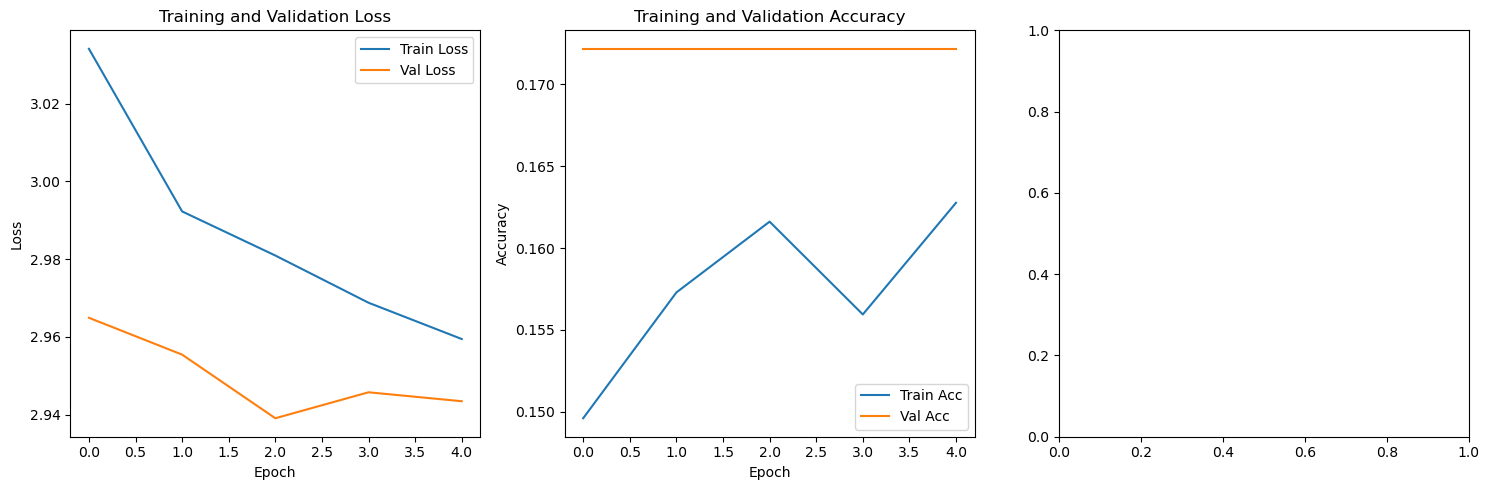

In [14]:
# 訓練結果の可視化
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
# 検証データでの最終評価
val_loss, val_acc, val_preds, val_targets = mt.evaluate(model, val_loader, criterion, device)
print(f"最終検証精度: {val_acc:.4f}")

# クラス名とラベルの対応を確認
class_names = train_dataset.label_encoder.classes_
print(f"全クラス数: {len(class_names)}")
print(f"検証データに含まれるユニークなクラス数: {len(set(val_targets))}")
print(f"予測に含まれるユニークなクラス数: {len(set(val_preds))}")

# 実際に使用されているクラスのみを取得
unique_labels = sorted(set(val_targets) | set(val_preds))
actual_class_names = [class_names[i] for i in unique_labels]

print(f"実際に使用されているクラス: {actual_class_names}")

# 分類レポート（実際に使用されているクラスのみ）
print("\n分類レポート:")
print(classification_report(
    val_targets, 
    val_preds, 
    labels=unique_labels,
    target_names=actual_class_names, 
    zero_division=0
))

# 追加の統計情報
print(f"\n詳細統計:")
print(f"検証データのクラス分布:")
unique_targets, target_counts = np.unique(val_targets, return_counts=True)
for label, count in zip(unique_targets, target_counts):
    class_name = class_names[label]
    print(f"  {class_name}: {count}サンプル")

plt.tight_layout()
plt.show()

In [15]:
# クラス分布の詳細分析
print("=== クラス分布の詳細分析 ===")

# 訓練データのクラス分布
train_labels = [train_dataset.encoded_labels[i] for i in range(len(train_dataset))]
train_unique, train_counts = np.unique(train_labels, return_counts=True)

print(f"\n訓練データのクラス分布:")
for label, count in zip(train_unique, train_counts):
    class_name = class_names[label]
    print(f"  {class_name}: {count}サンプル")

# 検証データのクラス分布
val_labels = [val_dataset.encoded_labels[i] for i in range(len(val_dataset))]
val_unique, val_counts = np.unique(val_labels, return_counts=True)

print(f"\n検証データのクラス分布:")
for label, count in zip(val_unique, val_counts):
    class_name = class_names[label]
    print(f"  {class_name}: {count}サンプル")

# 訓練データにあって検証データにないクラス
train_only = set(train_unique) - set(val_unique)
if train_only:
    print(f"\n訓練データにのみ存在するクラス:")
    for label in sorted(train_only):
        print(f"  {class_names[label]}")

# 検証データにあって訓練データにないクラス
val_only = set(val_unique) - set(train_unique)
if val_only:
    print(f"\n検証データにのみ存在するクラス:")
    for label in sorted(val_only):
        print(f"  {class_names[label]}")

=== クラス分布の詳細分析 ===

訓練データのクラス分布:
  E: 58サンプル
  M: 257サンプル
  N: 712サンプル
  ORF10: 67サンプル
  ORF3a: 543サンプル
  ORF6: 94サンプル
  ORF7a: 318サンプル
  ORF7b: 70サンプル
  ORF8: 335サンプル
  S: 1382サンプル
  non_coding1: 119サンプル
  non_coding10: 23サンプル
  non_coding11: 267サンプル
  non_coding2: 2サンプル
  non_coding4: 8サンプル
  non_coding5: 8サンプル
  non_coding7: 22サンプル
  non_coding8: 10サンプル
  non_coding9: 1サンプル
  nsp1: 217サンプル
  nsp10: 67サンプル
  nsp12: 629サンプル
  nsp13: 450サンプル
  nsp14: 468サンプル
  nsp15: 231サンプル
  nsp16: 226サンプル
  nsp2: 737サンプル
  nsp3: 1769サンプル
  nsp4: 374サンプル
  nsp5: 301サンプル
  nsp6: 291サンプル
  nsp7: 77サンプル
  nsp8: 160サンプル
  nsp9: 121サンプル

検証データのクラス分布:
  E: 15サンプル
  M: 63サンプル
  N: 189サンプル
  ORF10: 21サンプル
  ORF3a: 144サンプル
  ORF6: 34サンプル
  ORF7a: 60サンプル
  ORF7b: 15サンプル
  ORF8: 96サンプル
  S: 336サンプル
  non_coding1: 22サンプル
  non_coding10: 6サンプル
  non_coding11: 41サンプル
  non_coding2: 1サンプル
  non_coding4: 1サンプル
  non_coding5: 3サンプル
  non_coding7: 8サンプル
  non_coding8: 1サンプル
  non_coding9: 1サンプル
  nsp1: 44サンプル
  nsp10:

タイムステップごとのテスト評価を開始します...
=== タイムステップごとのテスト評価 ===

タイムステップ 31 の評価中...
  フィルタリング: 2182 -> 1657 サンプル
  サンプル数: 1658 (展開後: 2182, フィルタ後: 1657)
  Loss: 3.4691
  厳密精度: 0.0585
  柔軟精度: 0.0893

タイムステップ 32 の評価中...
  フィルタリング: 1378 -> 1040 サンプル
  サンプル数: 1040 (展開後: 1378, フィルタ後: 1040)
  Loss: 3.5353
  厳密精度: 0.0808
  柔軟精度: 0.1163

タイムステップ 33 の評価中...
  フィルタリング: 790 -> 576 サンプル
  サンプル数: 576 (展開後: 790, フィルタ後: 576)
  Loss: 3.3886
  厳密精度: 0.0747
  柔軟精度: 0.1146

タイムステップ 34 の評価中...
  フィルタリング: 417 -> 287 サンプル
  サンプル数: 287 (展開後: 417, フィルタ後: 287)
  Loss: 3.5488
  厳密精度: 0.0453
  柔軟精度: 0.0906

タイムステップ 35 の評価中...
  フィルタリング: 205 -> 139 サンプル
  サンプル数: 139 (展開後: 205, フィルタ後: 139)
  Loss: 3.5378
  厳密精度: 0.0647
  柔軟精度: 0.1151

タイムステップ 36 の評価中...
  フィルタリング: 92 -> 62 サンプル
  サンプル数: 62 (展開後: 92, フィルタ後: 62)
  Loss: 3.5987
  厳密精度: 0.0806
  柔軟精度: 0.2258

タイムステップ 37 の評価中...
  フィルタリング: 45 -> 34 サンプル
  サンプル数: 34 (展開後: 45, フィルタ後: 34)
  Loss: 3.8912
  厳密精度: 0.0588
  柔軟精度: 0.0882

タイムステップ 38 の評価中...
  フィルタリング: 49 -> 24 サンプル
  サンプル数: 2

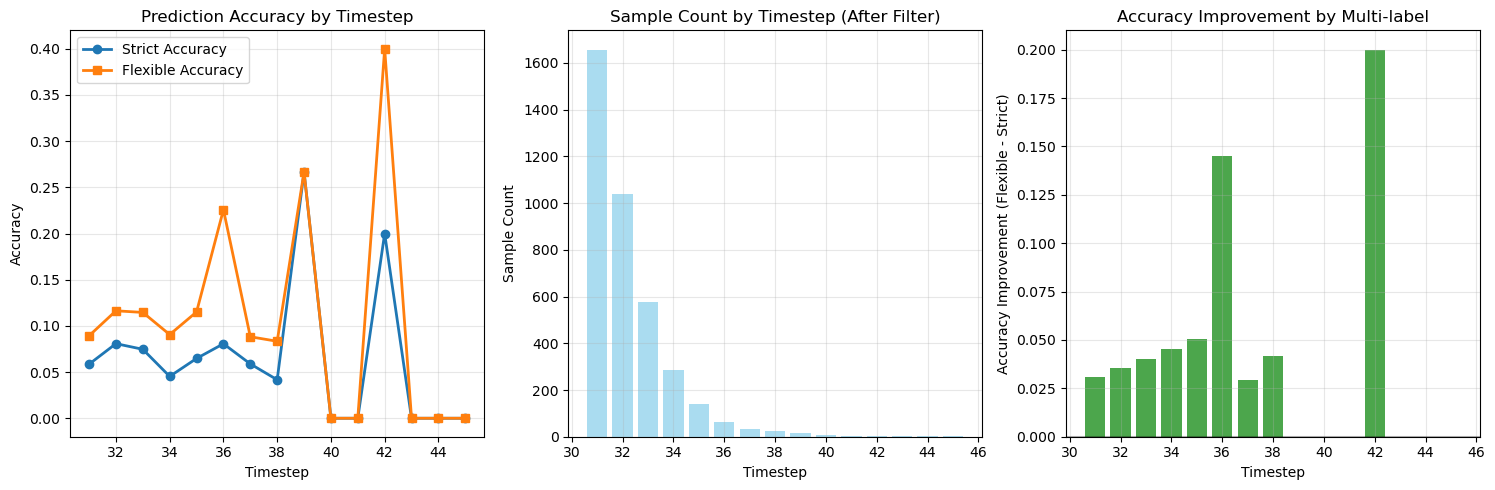


=== Detailed Analysis by Timestep ===

--- Timestep 31 ---
Samples: 1658 (Expanded: 2182, Filtered: 1657)
Loss: 3.4691
Strict Accuracy: 0.0585
Flexible Accuracy: 0.0893
Accuracy Improvement: 0.0308
Target Class Distribution:
  E: 10 samples
  M: 53 samples
  N: 112 samples
  ORF10: 8 samples
  ORF3a: 98 samples
  ORF6: 21 samples
  ORF7a: 38 samples
  ORF7b: 21 samples
  ORF8: 76 samples
  S: 215 samples
  non_coding1: 10 samples
  non_coding10: 8 samples
  non_coding11: 55 samples
  non_coding2: 1 samples
  non_coding4: 4 samples
  non_coding5: 1 samples
  non_coding7: 4 samples
  non_coding8: 2 samples
  non_coding9: 2 samples
  nsp1: 25 samples
  nsp10: 8 samples
  nsp12: 103 samples
  nsp13: 67 samples
  nsp14: 76 samples
  nsp15: 27 samples
  nsp16: 19 samples
  nsp2: 112 samples
  nsp3: 310 samples
  nsp4: 48 samples
  nsp5: 37 samples
  nsp6: 44 samples
  nsp7: 9 samples
  nsp8: 24 samples
  nsp9: 9 samples

--- Timestep 32 ---
Samples: 1040 (Expanded: 1378, Filtered: 1040)
Los

In [16]:
print("タイムステップごとのテスト評価を開始します...")
timestep_results = ev.evaluate_test_data_timestep(model, test_x, test_y, feature_vocabs, val_dataset, device, criterion)

# 結果の再可視化（英語ラベル）
print("Re-plotting results with English labels...")
ev.plot_timestep_results(timestep_results)

# 詳細分析の表示
ev.print_detailed_timestep_analysis(timestep_results, train_dataset)

# サマリーを表示
ev.print_test_summary(timestep_results)

=== モデルと結果の保存を開始 ===
最良モデルを保存: ../model/20250628_train1/best_model.pth
現在のモデルを保存: ../model/20250628_train1/current_model.pth
オプティマイザー状態を保存: ../model/20250628_train1/optimizer.pth
スケジューラー状態を保存: ../model/20250628_train1/scheduler.pth
設定ファイルを保存: ../model/20250628_train1/config.json
語彙辞書を保存: ../model/20250628_train1/feature_vocabularies.pkl
ラベルエンコーダーを保存: ../model/20250628_train1/label_encoder.pkl
訓練履歴グラフを保存: ../model/20250628_train1/training_history.png


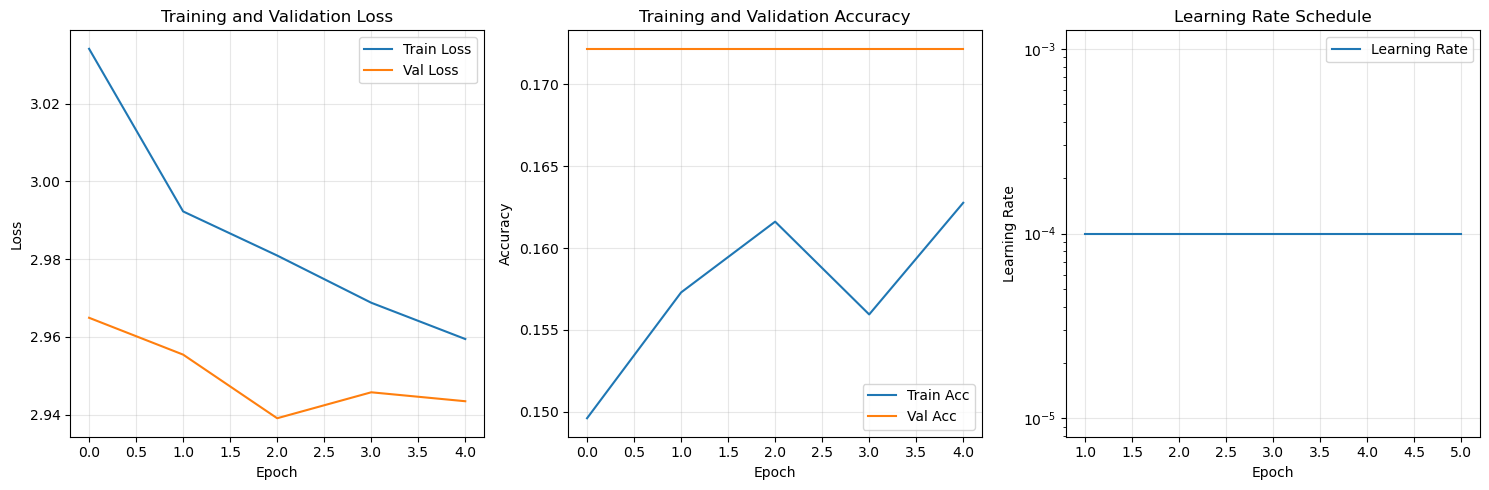

テスト結果を保存: ../model/20250628_train1/test_results.json
テスト結果グラフを保存: ../model/20250628_train1/test_results.png


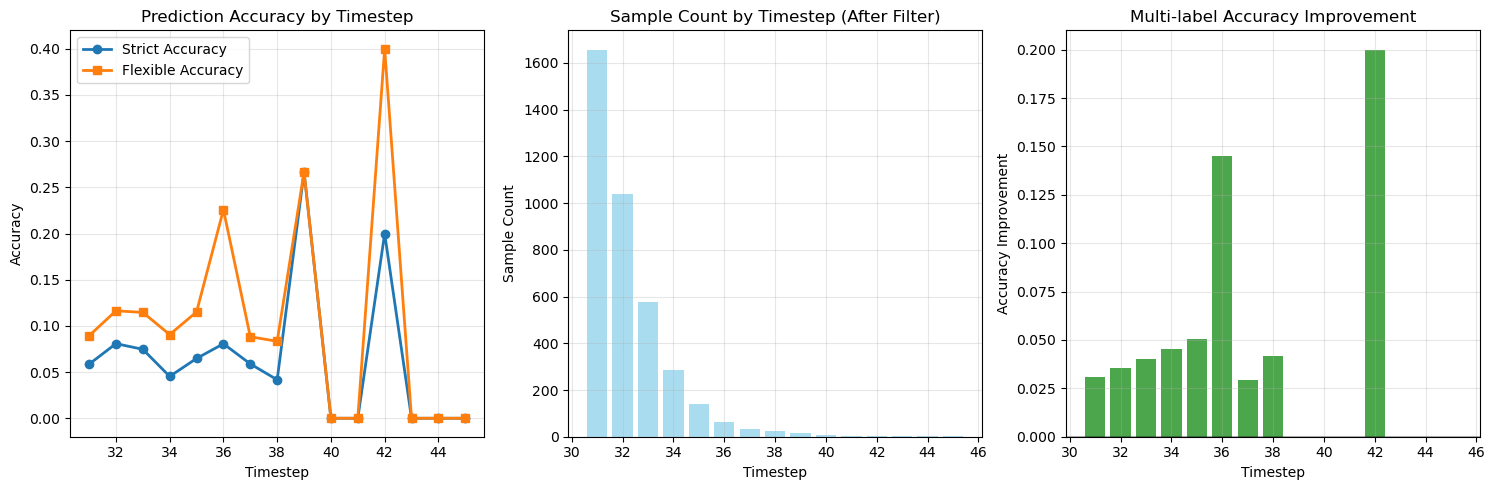

READMEファイルを保存: ../model/20250628_train1/README.md

=== 全ての保存が完了しました ===
保存先: /mnt/ssd1/home3/aiba/model/20250628_train1
保存ファイル数: 12
保存されたファイル:
  README.md: 2,761 bytes
  best_model.pth: 18,704,034 bytes
  config.json: 2,475 bytes
  current_model.pth: 18,707,115 bytes
  experiment_summary.json: 744 bytes
  feature_vocabularies.pkl: 763,268 bytes
  label_encoder.pkl: 1,871 bytes
  optimizer.pth: 37,419,514 bytes
  scheduler.pth: 1,192 bytes
  test_results.json: 76,949 bytes
  test_results.png: 290,352 bytes
  training_history.png: 235,732 bytes
実験サマリーを保存: ../model/20250628_train1/experiment_summary.json

=== 修正版での保存が完了しました ===
保存先: /mnt/ssd1/home3/aiba/model/20250628_train1
保存ファイル数: 12
保存されたファイル:
  README.md: 2,761 bytes
  best_model.pth: 18,704,034 bytes
  config.json: 2,475 bytes
  current_model.pth: 18,707,115 bytes
  experiment_summary.json: 744 bytes
  feature_vocabularies.pkl: 763,268 bytes
  label_encoder.pkl: 1,871 bytes
  optimizer.pth: 37,419,514 bytes
  scheduler.pth: 1,192 by

In [31]:
# 全ての保存処理を実行
print("=== モデルと結果の保存を開始 ===")

# 1. モデルの保存
save.save_model_and_training_state(save_dir, best_model_state, model, optimizer, scheduler)

# 2. 設定の保存
save.save_hyperparameters_and_config(strains, nmax, nmax_per_strain, test_start, ylen, val_ratio,
                                     feature_idx, train_dataset, val_dataset, model,
                                     num_epochs, batch_size, train_losses, val_losses,
                                     train_accs, val_accs, best_val_acc, feature_vocabs,
                                     device, save_dir)

# 3. 語彙辞書の保存
save.save_vocabularies(save_dir, feature_vocabs, train_dataset)

# 4. 訓練履歴の保存
save.save_training_plots(train_losses, val_losses, train_accs, val_accs, scheduler, save_dir)

# 5. テスト結果の保存
save.save_test_results(timestep_results, save_dir)

# 6. READMEの保存
save.save_readme(strains, model, train_dataset, val_dataset,
                  num_epochs, train_accs, val_accs, best_val_acc,
                  feature_vocabs, save_dir)

print(f"\n=== 全ての保存が完了しました ===")
print(f"保存先: {os.path.abspath(save_dir)}")
print(f"保存ファイル数: {len(os.listdir(save_dir))}")
print("保存されたファイル:")
for file in sorted(os.listdir(save_dir)):
    file_path = os.path.join(save_dir, file)
    size = os.path.getsize(file_path)
    print(f"  {file}: {size:,} bytes")

# 実験サマリーを保存
save.save_experiment_summary(strains, train_dataset, val_dataset, model,
                             num_epochs, train_accs, val_accs, best_val_acc,
                             timestep_results, save_dir)

print(f"\n=== 修正版での保存が完了しました ===")
print(f"保存先: {os.path.abspath(save_dir)}")

# 最終的なファイル確認
if os.path.exists(save_dir):
    files = os.listdir(save_dir)
    print(f"保存ファイル数: {len(files)}")
    print("保存されたファイル:")
    for file in sorted(files):
        file_path = os.path.join(save_dir, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            print(f"  {file}: {size:,} bytes")
    
    # 保存完了の確認
    expected_files = [
        "best_model.pth", "config.json", "feature_vocabularies.pkl", 
        "label_encoder.pkl", "training_history.png", "test_results.json",
        "README.md", "experiment_summary.json"
    ]
    
    missing_files = [f for f in expected_files if f not in files]
    if missing_files:
        print(f"\n警告: 以下のファイルが見つかりません: {missing_files}")
    else:
        print(f"\n✅ 全ての重要ファイルが正常に保存されました")
else:
    print(f"❌ 保存ディレクトリが見つかりません: {save_dir}")